### Import Libraries

In [1]:
# Pre Processing 
import pandas as pd
import datetime as dt
import numpy as np

# Exploratory Data
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import squarify 
%matplotlib inline

# Pycaret Environment
from pycaret.clustering import *
from pycaret.clustering import setup

### Load Online Retail Data

In [2]:
Ret = pd.read_csv('OnlineRetail.csv',  encoding= 'unicode_escape')
pd.set_option('display.max_columns', None)
Ret

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


### Dataset Profiling

In [3]:
def dataset_profile(csv):
    print("Dataset dimension :", csv.ndim)
    print("Dataset shape :", csv.shape)
    print("Dataset size :", csv.size)

dataset_profile(Ret)

Dataset dimension : 2
Dataset shape : (541909, 8)
Dataset size : 4335272


In [4]:
def features_types(csv):
    types = csv.dtypes.reset_index()
    types.columns = ['Features','Data Type']
    return types

features_types(Ret)

,Features,Data Type
0,InvoiceNo,object
1,StockCode,object
2,Description,object
3,Quantity,int64
4,InvoiceDate,object
5,UnitPrice,float64
6,CustomerID,float64
7,Country,object


### Dataset Inspection

### Missing and Blank Values Checking

In [5]:
missing_data = Ret.isnull().sum().reset_index()
missing_data.columns = ['Features','Missing Values']
blank_data = Ret.apply(lambda x : x == '.').sum().reset_index()
blank_data.columns = ['Features','Blank Values']
merged_data = pd.merge(missing_data, blank_data, on=['Features'])
merged_data['Filling Factor'] = (Ret.shape[0]-missing_data['Missing Values'] + Ret.shape[0]-blank_data['Blank Values'])/Ret.shape[0]*50
merged_data.sort_values(by='Filling Factor',ascending=True)

,Features,Missing Values,Blank Values,Filling Factor
6,CustomerID,135080,0,87.536653
2,Description,1454,0,99.865845
0,InvoiceNo,0,0,100.000000
1,StockCode,0,0,100.000000
3,Quantity,0,0,100.000000
4,InvoiceDate,0,0,100.000000
5,UnitPrice,0,0,100.000000
7,Country,0,0,100.000000


### Cross Checking Missing Values with ASSERT Statement

In [6]:
# Assert that there are no missing values in the dataframe

assert pd.notnull(Ret).all().all()

AssertionError: 

Interpretation
 - The above command does indeed throw an error. Hence, it is confirmed that there are missing or negative values in the dataset
 - Some of the values within dataset either missing or negative.
 - Proceed to data cleaning

### Dataset Overview

In [7]:
def initial_eda(df):
    if isinstance(df, pd.DataFrame):
        total_na = df.isna().sum().sum()
        print("Dimensions : %d rows, %d columns" % (df.shape[0], df.shape[1]))
        print("Total NA Values : %d " % (total_na))
        print("%38s %10s     %10s %10s" % ("Column Name", "Data Type", "#Distinct", "NA Values"))
        col_name = df.columns
        dtyp = df.dtypes
        uniq = df.nunique()
        na_val = df.isna().sum()
        for i in range(len(df.columns)):
            print("%38s %10s   %10s %10s" % (col_name[i], dtyp[i], uniq[i], na_val[i]))
        
    else:
        print("Expect a DataFrame but got a %15s" % (type(df)))
        
initial_eda(Ret)

Dimensions : 541909 rows, 8 columns
Total NA Values : 136534 
                           Column Name  Data Type      #Distinct  NA Values
                             InvoiceNo     object        25900          0
                             StockCode     object         4070          0
                           Description     object         4223       1454
                              Quantity      int64          722          0
                           InvoiceDate     object        23260          0
                             UnitPrice    float64         1630          0
                            CustomerID    float64         4372     135080
                               Country     object           38          0


### Categorical Features

In [8]:
categorical = [var for var in Ret.columns if Ret[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

There are 5 categorical variables

The categorical variables are :

 ['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'Country']


### Numerical Features 

In [9]:
numericalint = [var for var in Ret.columns if Ret[var].dtype=='int64']
numericalfloat = [var for var in Ret.columns if Ret[var].dtype=='float64']
numerical = numericalint + numericalfloat

print('There are {} numerical variables\n'.format(len(numerical)))

print('The numerical variables are :\n\n', numerical)

There are 3 numerical variables

The numerical variables are :

 ['Quantity', 'UnitPrice', 'CustomerID']


### Categorical Features Distinc Value Distribution

In [10]:
for var in categorical: 
    jumlah1 = len(Ret[var].unique())
    print(f'There are', jumlah1,'unique values in')
    print(f'Count of each values are:','\n', Ret[var].value_counts(),'\n')

There are 25900 unique values in
Count of each values are: 
 573585     1114
581219      749
581492      731
580729      721
558475      705
           ... 
554023        1
554022        1
554021        1
554020        1
C558901       1
Name: InvoiceNo, Length: 25900, dtype: int64 

There are 4070 unique values in
Count of each values are: 
 85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
21431        1
22275        1
17001        1
90187A       1
72759        1
Name: StockCode, Length: 4070, dtype: int64 

There are 4224 unique values in
Count of each values are: 
 WHITE HANGING HEART T-LIGHT HOLDER     2369
REGENCY CAKESTAND 3 TIER               2200
JUMBO BAG RED RETROSPOT                2159
PARTY BUNTING                          1727
LUNCH BAG RED RETROSPOT                1638
                                       ... 
Missing                                   1
historic computer difference?....se       1
DUSTY PINK CHRISTMAS TREE 30CM   

### Categorical Values Abnormal Values Checking

In [11]:
for var in categorical: 
    print(Ret[var].loc[Ret[var].str.contains(',|%|@|!|#|`',na=False)])
    jumlah = Ret[var].str.contains(',|%|@|!|#|&|`',na=False).sum()
    print('There are {} abnormal values\n'.format(jumlah))

Series([], Name: InvoiceNo, dtype: object)
There are 0 abnormal values

Series([], Name: StockCode, dtype: object)
There are 0 abnormal values

109                 AIRLINE LOUNGE,METAL SIGN
253                FANCY FONT BIRTHDAY CARD, 
956                    TRAY, BREAKFAST IN BED
1014       SWISS ROLL TOWEL, CHOCOLATE  SPOTS
1083       SWISS ROLL TOWEL, CHOCOLATE  SPOTS
                         ...                 
541255          NURSERY A,B,C PAINTED LETTERS
541343       SET 3 RETROSPOT TEA,COFFEE,SUGAR
541549    DIAMANTE HEART SHAPED WALL MIRROR, 
541614     SWISS ROLL TOWEL, CHOCOLATE  SPOTS
541787             FANCY FONT BIRTHDAY CARD, 
Name: Description, Length: 4861, dtype: object
There are 7579 abnormal values

Series([], Name: InvoiceDate, dtype: object)
There are 0 abnormal values

Series([], Name: Country, dtype: object)
There are 0 abnormal values



### Data Cleaning : Handling MIssing Values

In [12]:
Ret = Ret.dropna(axis = 0, how ='any')
Ret

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


### Features Missing Values Handling

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = SimpleImputer(strategy='most_frequent')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ])
# Fit to Dataframe
array_prepared = preprocessor.fit_transform(Ret)

# Converts the array to Dataframe
my_cols = numerical + categorical
Ret = pd.DataFrame(array_prepared, 
             columns=(list(my_cols)))

# Replace Features type to Their Correct Ones
Ret[numericalint] = Ret[numericalint].astype('int64')
Ret[numericalfloat] = Ret[numericalfloat].astype('float64')
Ret

,Quantity,UnitPrice,CustomerID,InvoiceNo,StockCode,Description,InvoiceDate,Country
0,6,2.55,17850.0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,12/1/2010 8:26,United Kingdom
1,6,3.39,17850.0,536365,71053,WHITE METAL LANTERN,12/1/2010 8:26,United Kingdom
2,8,2.75,17850.0,536365,84406B,CREAM CUPID HEARTS COAT HANGER,12/1/2010 8:26,United Kingdom
3,6,3.39,17850.0,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,12/1/2010 8:26,United Kingdom
4,6,3.39,17850.0,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,12/1/2010 8:26,United Kingdom
...,...,...,...,...,...,...,...,...
406824,12,0.85,12680.0,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12/9/2011 12:50,France
406825,6,2.10,12680.0,581587,22899,CHILDREN'S APRON DOLLY GIRL,12/9/2011 12:50,France
406826,4,4.15,12680.0,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,12/9/2011 12:50,France
406827,4,4.15,12680.0,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,12/9/2011 12:50,France


### Cross Checking For Missing Values in Dataset

In [14]:
# Assert that there are no missing values in the dataframe
assert pd.notnull(Ret).all().all()
initial_eda(Ret)

Dimensions : 406829 rows, 8 columns
Total NA Values : 0 
                           Column Name  Data Type      #Distinct  NA Values
                              Quantity      int64          436          0
                             UnitPrice    float64          620          0
                            CustomerID    float64         4372          0
                             InvoiceNo     object        22190          0
                             StockCode     object         3684          0
                           Description     object         3896          0
                           InvoiceDate     object        20460          0
                               Country     object           37          0


### Recency, Frequency and Monetary Dataset Filtering

### Monetary

In [15]:
Ret['Amount'] = Ret['UnitPrice']* Ret['Quantity']
Mon = Ret.groupby('CustomerID')['Amount'].sum().reset_index()
Mon

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
...,...,...
4367,18280.0,180.60
4368,18281.0,80.82
4369,18282.0,176.60
4370,18283.0,2094.88


### Frequency

In [16]:
Freq = Ret.groupby('CustomerID')['InvoiceNo'].count().reset_index()
Freq

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
...,...,...
4367,18280.0,10
4368,18281.0,7
4369,18282.0,13
4370,18283.0,756


### Recency

In [17]:
Ret['InvoiceDate'] = pd.to_datetime(Ret['InvoiceDate'], format ='%m/%d/%Y %H:%M')
Ret['Diff'] = max(Ret['InvoiceDate']) - Ret['InvoiceDate']
Renc = Ret.groupby('CustomerID')['Diff'].min().dt.days.reset_index()
Renc

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309
...,...,...
4367,18280.0,277
4368,18281.0,180
4369,18282.0,7
4370,18283.0,3


### Combine the Three Dataset Above

In [18]:
RFM = pd.merge(Mon,Freq, on = 'CustomerID', how = 'inner')
RFM = pd.merge(RFM, Renc, on = 'CustomerID', how = 'inner')
col_names = ['CustomerID','Monetary','Frequency','Recency']
RFM.columns = col_names
RFM = RFM.loc[RFM['Monetary'] > 0]
RFM

,CustomerID,Monetary,Frequency,Recency
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309
5,12352.0,1545.41,95,35
...,...,...,...,...
4367,18280.0,180.60,10,277
4368,18281.0,80.82,7,180
4369,18282.0,176.60,13,7
4370,18283.0,2094.88,756,3


### Determining Quantiles Values RFM

In [25]:
quant_RFM = RFM[['Recency','Frequency','Monetary']].quantile(q = [0.25,0.50,0.75])
quant_RFM

,Recency,Frequency,Monetary
0.25,16.0,18.00,302.2925
0.50,48.5,42.00,657.5500
0.75,137.0,102.75,1625.7400


### Determining RFM Joint Score

In [26]:
# Define function to score RFM:
def R_score(data):
    if data < quant_RFM['Recency'][0.25]:
        return 4
    elif data < quant_RFM['Recency'][0.50]:
        return 3
    elif data < quant_RFM['Recency'][0.75]:
        return 2    
    else:
        return 1
    
def F_score(data):
    if data < quant_RFM['Frequency'][0.25]:
        return 1
    elif data < quant_RFM['Frequency'][0.50]:
        return 2
    elif data < quant_RFM['Frequency'][0.75]:
        return 3    
    else:
        return 4    
    
    
def M_score(data):
    if data < quant_RFM['Monetary'][0.25]:
        return 1
    elif data < quant_RFM['Monetary'][0.50]:
        return 2
    elif data < quant_RFM['Monetary'][0.75]:
        return 3    
    else:
        return 4
    
# Apply to Dataset
RFM['R Score'] = RFM.Recency.apply(lambda x : R_score(x))
RFM['F Score'] = RFM.Frequency.apply(lambda x : F_score(x))
RFM['M Score'] = RFM.Monetary.apply(lambda x : M_score(x))
RFM['RFM Score'] = RFM['R Score'].map(str) + RFM['F Score'].map(str) + RFM['M Score'].map(str)

# Change rfm score data type into integer for further analysis
RFM['RFM Score'] = RFM['RFM Score'].astype('int64')
RFM

,CustomerID,Monetary,Frequency,Recency,R Score,F Score,M Score,RFM Score
1,12347.0,4310.00,182,1,4,4,4,444
2,12348.0,1797.24,31,74,2,2,4,224
3,12349.0,1757.55,73,18,3,3,4,334
4,12350.0,334.40,17,309,1,1,2,112
5,12352.0,1545.41,95,35,3,3,3,333
...,...,...,...,...,...,...,...,...
4367,18280.0,180.60,10,277,1,1,1,111
4368,18281.0,80.82,7,180,1,1,1,111
4369,18282.0,176.60,13,7,4,1,1,411
4370,18283.0,2094.88,756,3,4,4,4,444


### Recency, Frequency, Monetary Distribution

Text(0.5, 1.0, 'Monetary Distribution')

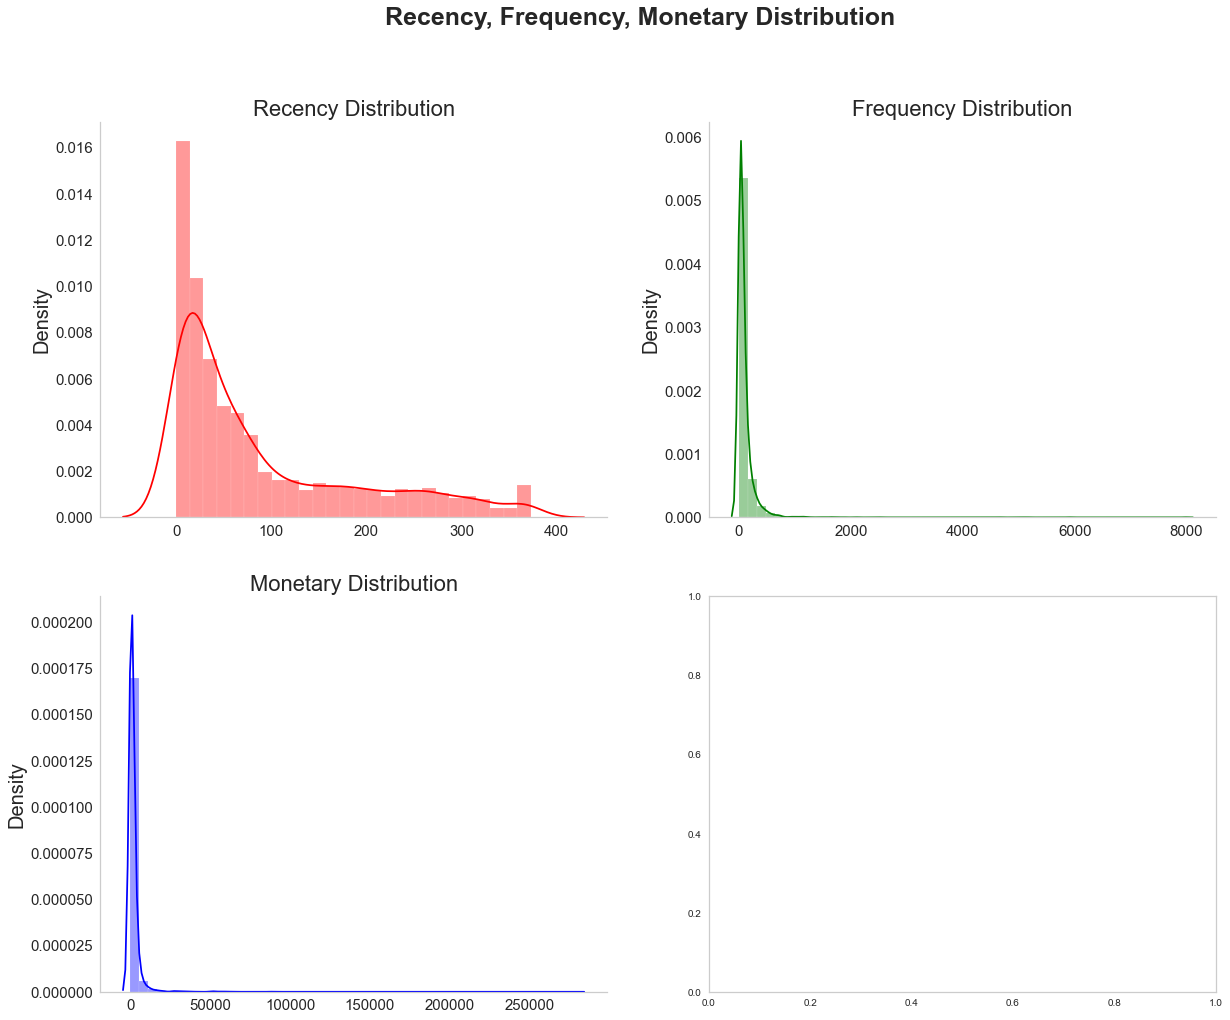

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(20,16))
fig.suptitle("Recency, Frequency, Monetary Distribution", fontsize=25,fontweight='bold', verticalalignment="top")

#Plot 1
plt.subplot(2,2,1)
ax1 = sns.distplot(x = RFM['Recency'], kde = True, ax=ax1, color = 'red')
ax1.set_ylabel('Density',fontsize=20,fontweight='normal')    
plt.xticks( fontsize=15)
plt.yticks( fontsize=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_title('Recency Distribution',fontsize=22, fontweight='normal')

# Plot 2
plt.subplot(2,2,2)
ax2 = sns.distplot(x = RFM['Frequency'], kde = True, ax=ax2, color = 'green')
ax2.set_ylabel('Density',fontsize=20,fontweight='normal')    
plt.xticks( fontsize=15)
plt.yticks( fontsize=15)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title('Frequency Distribution',fontsize=22, fontweight='normal')

# Plot 3
plt.subplot(2,2,3)
ax3 = sns.distplot(x = RFM['Monetary'], kde = True, ax=ax3, color = 'blue')
ax3.set_ylabel('Density',fontsize=20,fontweight='normal')    
plt.xticks( fontsize=15)
plt.yticks( fontsize=15)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_title('Monetary Distribution',fontsize=22, fontweight='normal')

### RFM Scoring Distribution

Text(0.5, 1.0, 'RFM Score Distribution')

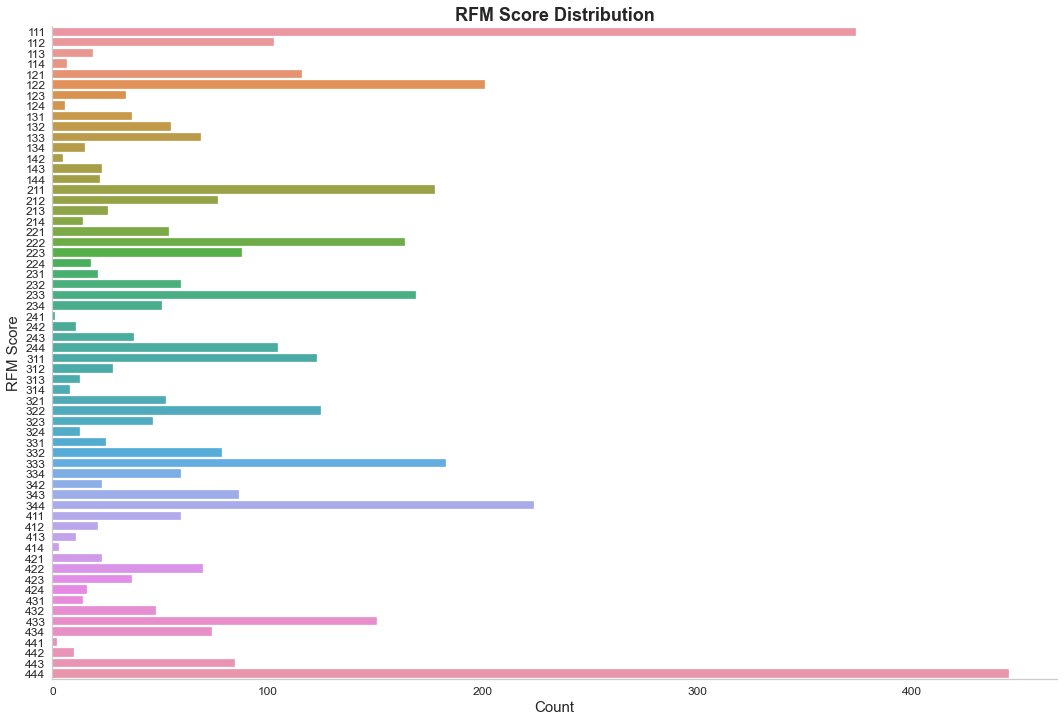

In [60]:
fig9=plt.figure(figsize=(18,12))
ax9 = sns.countplot(y='RFM Score', data=RFM.sort_values(by = ["RFM Score"], axis = 0))
ax9.set_ylabel('RFM Score',fontsize=15,fontweight='normal')    
ax9.set_xlabel('Count',fontsize=15,fontweight='normal') 
plt.xticks( fontsize=12)
plt.yticks( fontsize=12)
ax9.spines['right'].set_visible(False)
ax9.spines['top'].set_visible(False)
ax9.set_title('RFM Score Distribution',fontsize=18, fontweight='bold')

Customer here are segmented into 5 different categories as follows:

 - Loyal : Customers with the highest RFM Score of 444 point.
 - Champion : Customers with two 4 points of RFM score, having highest possibility to turn into loyal customer which is a very valuable assets for the company.
 - Average : Customers with an average score, having at least two 3 score or a combined of 3 & 4 score each.
 - At Risk : Customers with double 1, 2, or both point of RFM Score and without any of 4 on their RFM, for these type of customers, the company must handle this seriously so taht they dont turn to lost customers.
 - Ghost or Lost :Customers with the lowest RFM Score.

In [63]:
RFM['RFM Segment'] = np.select(
    [
     RFM['RFM Score'].isin([444]),
     RFM['RFM Score'].isin([234,243,244,324,334,333,342,343,344,423,424,432,433,434,442,443]),
     RFM['RFM Score'].isin([224,232,233,242,322,323,332,422,144,134,314,314,413,431,414,441]),
     RFM['RFM Score'].isin([122,123,124,132,133,142,212,213,214,221,222,223,231,241,312,313,321,331,412,421]),
     RFM['RFM Score'].isin([111,112,113,114,121,131,211,311,411])
    ],
    [
     'Loyal',
     'Champion',
     'Average',
     'At Risk',
     'Ghost or Lost'
    ]
)

RFM

,CustomerID,Monetary,Frequency,Recency,R Score,F Score,M Score,RFM Score,RFM Segment
1,12347.0,4310.00,182,1,4,4,4,444,Loyal
2,12348.0,1797.24,31,74,2,2,4,224,Average
3,12349.0,1757.55,73,18,3,3,4,334,Champion
4,12350.0,334.40,17,309,1,1,2,112,Ghost or Lost
5,12352.0,1545.41,95,35,3,3,3,333,Champion
...,...,...,...,...,...,...,...,...,...
4367,18280.0,180.60,10,277,1,1,1,111,Ghost or Lost
4368,18281.0,80.82,7,180,1,1,1,111,Ghost or Lost
4369,18282.0,176.60,13,7,4,1,1,411,Ghost or Lost
4370,18283.0,2094.88,756,3,4,4,4,444,Loyal


### Basic Statistics

In [64]:
RFM.describe()

,CustomerID,Monetary,Frequency,Recency,R Score,F Score,M Score,RFM Score
count,4322.000000,4.322000e+03,4322.000000,4322.000000,4322.000000,4322.000000,4322.00000,4322.000000
mean,15298.534475,1.923483e+03,94.059695,89.343591,2.496298,2.510875,2.50000,277.238547
std,1721.534033,8.263128e+03,233.621415,99.133565,1.117122,1.115001,1.11837,117.929565
min,12347.000000,1.776357e-15,1.000000,0.000000,1.000000,1.000000,1.00000,111.000000
25%,13812.250000,3.022925e+02,18.000000,16.000000,1.000000,2.000000,1.25000,144.000000
50%,15297.500000,6.575500e+02,42.000000,48.500000,2.500000,3.000000,2.50000,277.500000
75%,16777.750000,1.625740e+03,102.750000,137.000000,3.000000,3.750000,3.75000,344.000000
max,18287.000000,2.794890e+05,7983.000000,373.000000,4.000000,4.000000,4.00000,444.000000


### Data Preprocessing

### Preprocessing with pycaret

In [66]:
# Preprocessing 
grid = setup(data=RFM, session_id= 50, normalize = True, normalize_method = 'zscore', ignore_low_variance = True,
            ignore_features = ['CustomerID','RFM Segment'],ordinal_features = {'R Score' : ['1','2','3','4'],
             'F Score' : ['1','2','3','4'], 'M Score' : ['1','2','3','4']})

,Description,Value
0,session_id,50
1,Original Data,"(4322, 9)"
2,Missing Values,False
3,Numeric Features,4
4,Categorical Features,3
5,Ordinal Features,True
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(4322, 7)"
9,CPU Jobs,-1


### Creating Cluster Model (Default 4 Groups)

In [67]:
kmeans4 = create_model('kmeans', num_clusters=4, max_iter=50)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3728,2469.576,0.9644,0,0,0


In [68]:
print(kmeans4)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=50, tol=0.0001, verbose=0)


### Checking Cluster Optimal Grouping using Elbow Plot

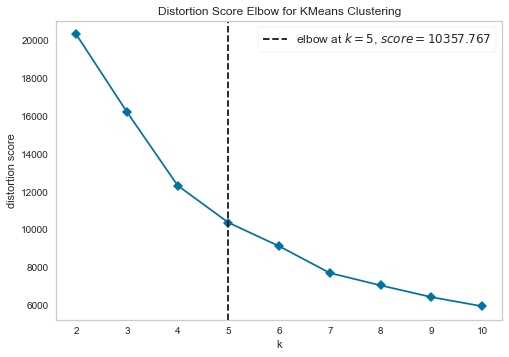

In [69]:
plot_model(kmeans4, plot = 'elbow')

### Creating Another Cluster Model with 5 different groups

In [70]:
kmeans5 = create_model('kmeans', num_clusters=5,max_iter=50)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3823,2406.8674,0.9062,0,0,0


In [71]:
print(kmeans5)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=50, tol=0.0001, verbose=0)


### Cluster Model Plotting

In [ ]:
plot_model(kmeans3)

### Assigning Model to Dataset

In [77]:
RFM_assign = assign_model(kmeans5)
RFM_assign

,CustomerID,Monetary,Frequency,Recency,R Score,F Score,M Score,RFM Score,RFM Segment,Cluster
1,12347.0,4310.00,182,1,4,4,4,444,Loyal,Cluster 0
2,12348.0,1797.24,31,74,2,2,4,224,Average,Cluster 4
3,12349.0,1757.55,73,18,3,3,4,334,Champion,Cluster 0
4,12350.0,334.40,17,309,1,1,2,112,Ghost or Lost,Cluster 1
5,12352.0,1545.41,95,35,3,3,3,333,Champion,Cluster 0
...,...,...,...,...,...,...,...,...,...,...
4367,18280.0,180.60,10,277,1,1,1,111,Ghost or Lost,Cluster 1
4368,18281.0,80.82,7,180,1,1,1,111,Ghost or Lost,Cluster 1
4369,18282.0,176.60,13,7,4,1,1,411,Ghost or Lost,Cluster 2
4370,18283.0,2094.88,756,3,4,4,4,444,Loyal,Cluster 0


### Cluster's Distribution Plot

In [78]:
plot_model(kmeans5, plot = 'distribution') #to see size of clusters

Text(0.5, 1.0, 'Cluster Size Distribution')

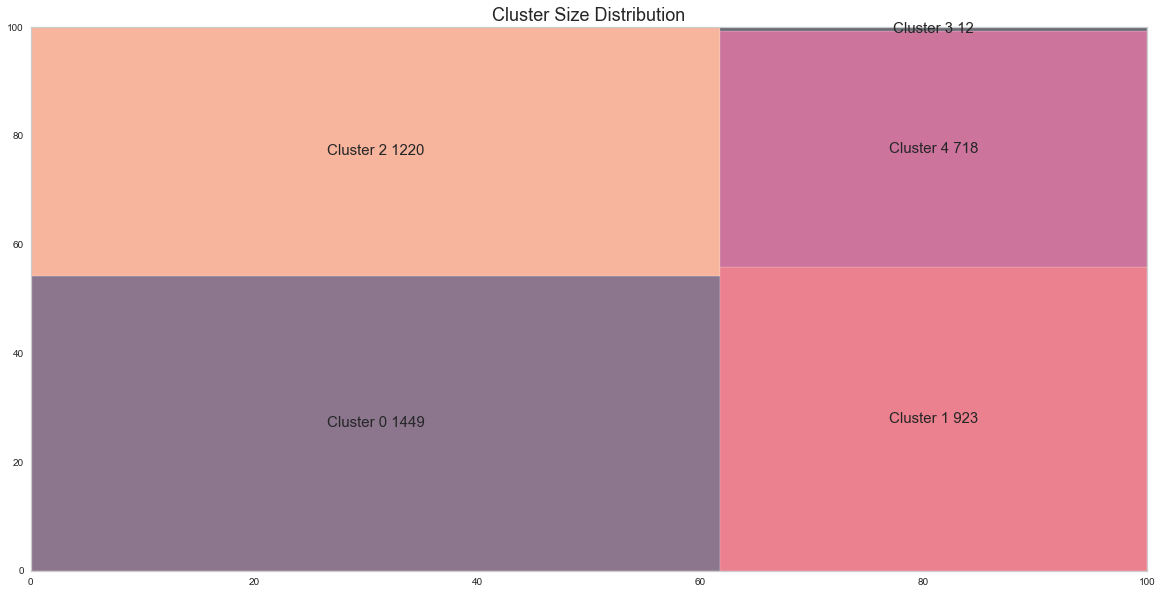

In [79]:
#Plot 1
fig1=plt.figure(figsize=(20,10))
size1 = RFM_assign.groupby('Cluster')['Cluster'].count().sort_values(ascending= False).tolist() 
label1 = RFM_assign.groupby('Cluster')['Cluster'].count().sort_values(ascending= False).index.values.tolist()
label1 = [i+" "+j for i, j in zip(label1, [str(x) for x in size1])]
ax1 = squarify.plot(sizes=size1, label=label1, alpha=.6, text_kwargs={'fontsize':15})
ax1.set_title('Cluster Size Distribution', fontsize=18, fontweight='normal')

In [ ]:
evaluate_model(kmeans3)

### Customer RFM Analysis with Radar Plot

In [80]:
# Scaling the numerical Values
RFM3 = RFM_assign[['Monetary','Frequency','Recency','Cluster']]
RFM4 = pd.DataFrame(RFM3.groupby('Cluster').median().reset_index(), columns=list(RFM3))
RFM5 = pd.DataFrame(RFM4['Cluster'])
RFM4.drop('Cluster',axis=1,inplace=True)
cols = RFM4.columns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

scaler = StandardScaler()

RFM4 = scaler.fit_transform(RFM4)
RFM4 = pd.DataFrame(RFM4, columns=[cols])

#Appending the 2 dataframes
Group = pd.concat([RFM4,RFM5],axis=1)
col_names = ['Monetary','Frequency','Recency','Cluster']
Group.columns = col_names
Group = Group.set_index("Cluster")
Group

,Monetary,Frequency,Recency
Cluster,,,
Cluster 0,-0.474904,-0.412792,-0.728844
Cluster 1,-0.515946,-0.552345,1.896325
Cluster 2,-0.514384,-0.547128,-0.413160
Cluster 3,1.999776,1.997441,-0.834073
Cluster 4,-0.494543,-0.485177,0.079752


### RFM Clusters Comparison

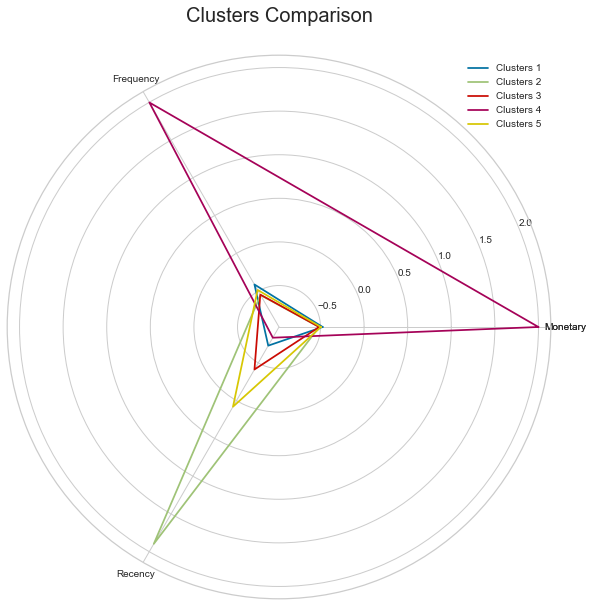

In [81]:
categories = list(Group)
categories = [*categories, categories[0]]

Clusters_1 = Group.iloc[0].values.tolist()
Clusters_2 = Group.iloc[1].values.tolist()
Clusters_3 = Group.iloc[2].values.tolist()
Clusters_4 = Group.iloc[3].values.tolist()
Clusters_5 = Group.iloc[4].values.tolist()

Clusters_1 = [*Clusters_1, Clusters_1[0]]
Clusters_2 = [*Clusters_2, Clusters_2[0]]
Clusters_3 = [*Clusters_3, Clusters_3[0]]
Clusters_4 = [*Clusters_4, Clusters_4[0]]
Clusters_5 = [*Clusters_5, Clusters_5[0]]


label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(Clusters_1))

plt.figure(figsize=(15, 10))
plt.subplot(polar=True)
plt.plot(label_loc, Clusters_1, label='Clusters 1')
plt.plot(label_loc, Clusters_2, label='Clusters 2')
plt.plot(label_loc, Clusters_3, label='Clusters 3')
plt.plot(label_loc, Clusters_4, label='Clusters 4')
plt.plot(label_loc, Clusters_5, label='Clusters 5')
plt.title('Clusters Comparison', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

### `Recency-Frequency` Scatter Plot

Text(0.5, 1.0, 'Recency-Frequency Plot')

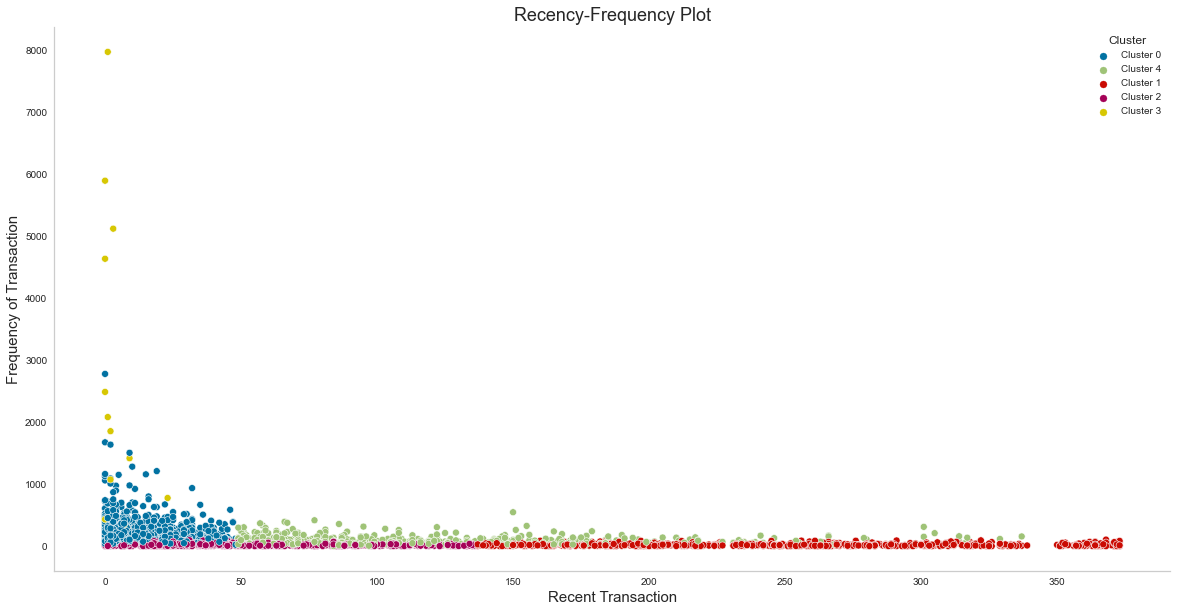

In [82]:
fig1=plt.figure(figsize=(20,10))
ax1 = sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=RFM_assign, color='b')
ax1.set_ylabel('Frequency of Transaction',fontsize=15,fontweight='normal')    
ax1.set_xlabel('Recent Transaction',fontsize=15,fontweight='normal') 
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_title('Recency-Frequency Plot',fontsize=18, fontweight='normal')

### `Recency-Monetary` Scatter Plot

Text(0.5, 1.0, 'Recency-Monetary Plot')

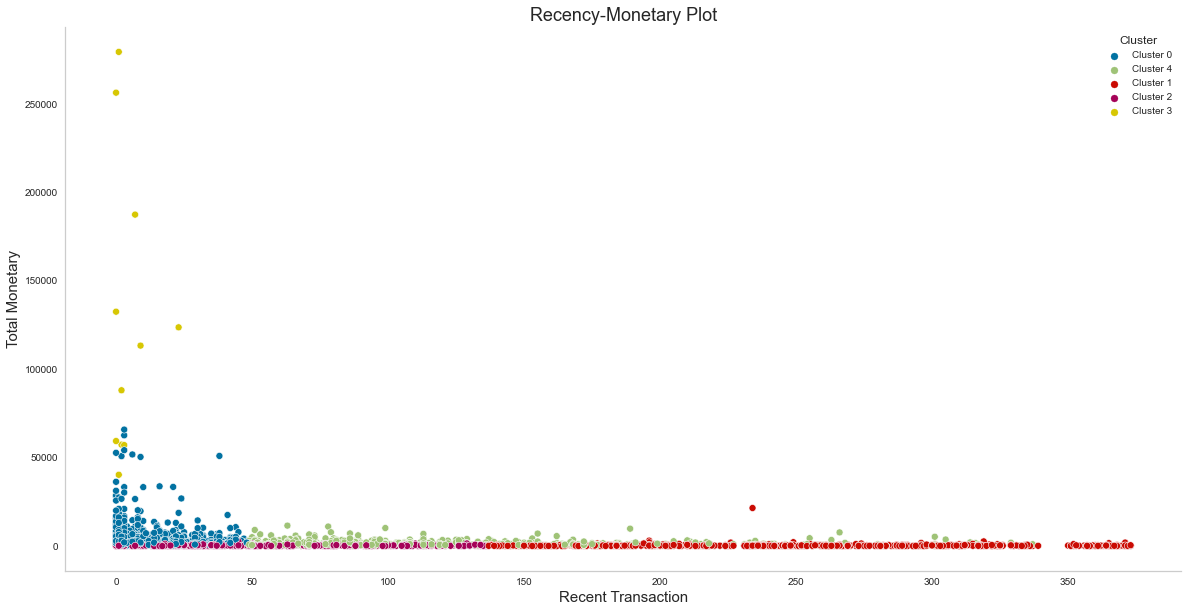

In [83]:
fig2=plt.figure(figsize=(20,10))
ax2 = sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=RFM_assign, color='b')
ax2.set_ylabel('Total Monetary',fontsize=15,fontweight='normal')    
ax2.set_xlabel('Recent Transaction',fontsize=15,fontweight='normal') 
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title('Recency-Monetary Plot',fontsize=18, fontweight='normal')

### `Frequency-Monetary` Scatter Plot

Text(0.5, 1.0, 'Monetary-Frequency Plot')

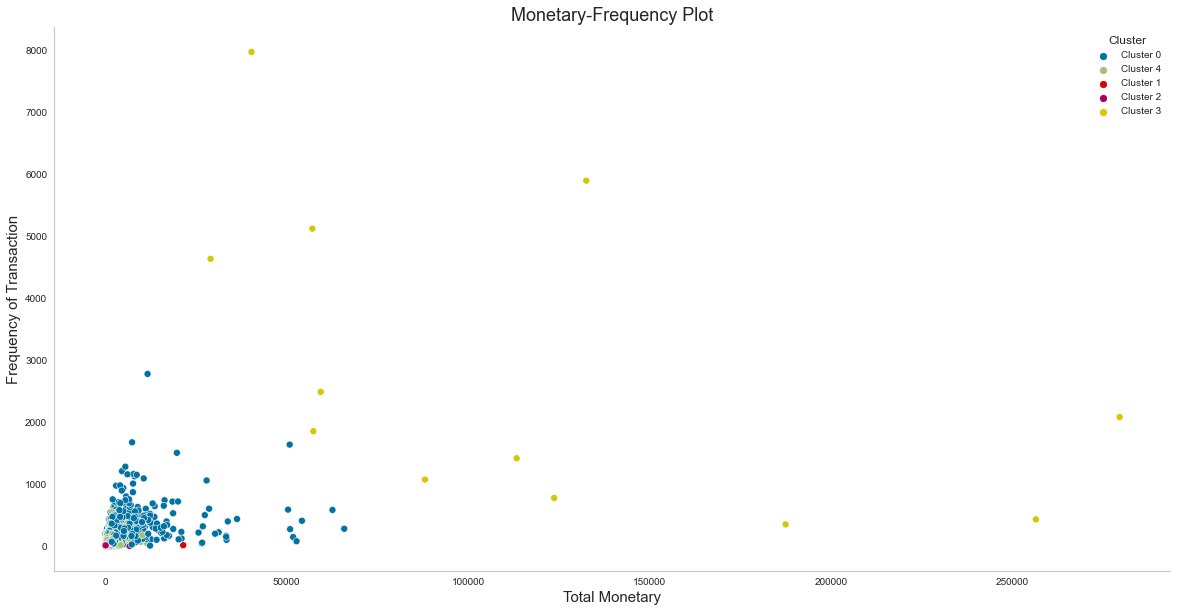

In [84]:
fig3=plt.figure(figsize=(20,10))
ax3 = sns.scatterplot(x='Monetary', y='Frequency', hue='Cluster', data=RFM_assign, color='b')
ax3.set_ylabel('Frequency of Transaction',fontsize=15,fontweight='normal')    
ax3.set_xlabel('Total Monetary',fontsize=15,fontweight='normal') 
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_title('Monetary-Frequency Plot',fontsize=18, fontweight='normal')